In [157]:
import torch
from torch.utils.data import DataLoader,Dataset,Subset
import matplotlib.pyplot as plt
import matplotlib
import pylab
from utils import My_dataset,train_val_dataset,split_A,plot_train_test_loss,apply_LPALM_realistic
from train import train_non_blind,train_blind
from ISTA import ISTA
from PALM import PALM
from LISTA import LISTA
import argparse
import numpy as np
import torch.nn as nn
import pickle
import matplotlib.image as mpimg

import copy as cp
from utils import prox_l1, prox_oblique
import scipy.io

### 1. Chargement des données

##### Données de ground truth

In [158]:
mat = scipy.io.loadmat('X_samson_normalized')
data = list(mat.items())
an_array = np.array(data,dtype=object)
X_samson_normalized = an_array[3,1]
#Tensor
X_samson_normalized = torch.reshape(torch.tensor(X_samson_normalized),[1,156,9025])

In [159]:
mat = scipy.io.loadmat('A_samson_normalized')
data = list(mat.items())
an_array = np.array(data,dtype=object)
A_samson_normalized = an_array[3,1]
#Tensor
A_samson_normalized = torch.reshape(torch.tensor(A_samson_normalized),[1,156,3])

In [160]:
mat = scipy.io.loadmat('S_samson')
data = list(mat.items())
an_array = np.array(data,dtype=object)
S_samson = an_array[3,1]
#Tensor
S_samson = torch.reshape(torch.tensor(S_samson),[1,3,9025])

##### Données estimées (SNPA)

In [161]:
mat = scipy.io.loadmat('A_snpa')
data = list(mat.items())
an_array = np.array(data,dtype=object)
A_snpa = an_array[3,1]

In [162]:
mat = scipy.io.loadmat('S_snpa')
data = list(mat.items())
an_array = np.array(data,dtype=object)
S_snpa = an_array[3,1]

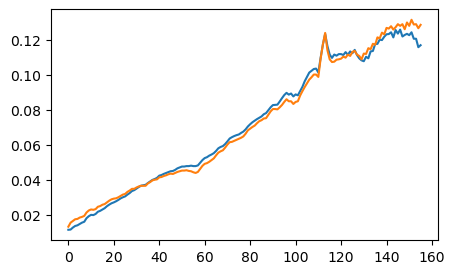

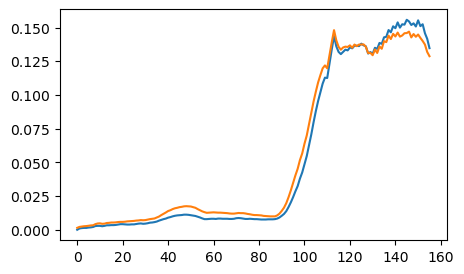

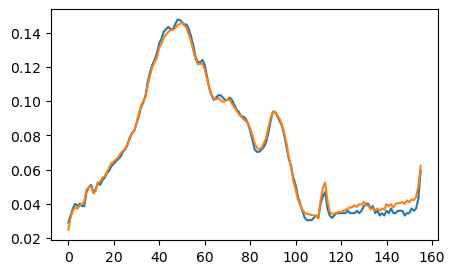

In [163]:
#Comparaison des spectres comparées et spectes estimés
plt.figure(figsize=(5,3))
plt.plot(A_snpa[:,0])
plt.plot(A_samson_normalized[0,:,0])

plt.figure(figsize=(5,3))
plt.plot(A_snpa[:,1])
plt.plot(A_samson_normalized[0,:,1])

plt.figure(figsize=(5,3))
plt.plot(A_snpa[:,2])
plt.plot(A_samson_normalized[0,:,2])

In [164]:
#Chargement des données d'entrainement
with open('samson_train_set.pickle', 'rb') as f:
      train_set = pickle.load(f)
with open('samson_val_set.pickle', 'rb') as f:
      val_set = pickle.load(f)
torch.manual_seed(42)
train_loader = DataLoader(train_set, batch_size=1, shuffle=False, num_workers=0) #4)
val_loader = DataLoader(val_set,batch_size=1, shuffle=False, num_workers=0) #4)

In [165]:
#Chargement des données d'entrainement de [LPALM_ReLU] (S_train issus de Dirichlet)
with open('samson_val_set (copie).pickle', 'rb') as f:
      train_set_1 = pickle.load(f)
with open('samson_val_set (copie).pickle', 'rb') as f:
      val_set_1 = pickle.load(f)
torch.manual_seed(42)
train_loader_1 = DataLoader(train_set_1, batch_size=1, shuffle=False, num_workers=0) #4)
val_loader_1 = DataLoader(val_set_1,batch_size=1, shuffle=False, num_workers=0) #4)

### 2. Evaluation du LPALM

In [166]:
#Chargement du réseau
model = torch.load('LPALM99.pth')
model.eval()

LPALM()

In [167]:
#Evaluation sur le jeu de données réel:

In [168]:
S_pred, A_pred, S_s, A_s = model(X_samson_normalized) #torch.tensor(np.reshape(val_set[p][0],(1,156,9025))))#X_realistic) #X_samson_normalized) #

In [169]:
#Estimated S
np.round(S_pred[0].detach().numpy(),3)

array([[0.   , 0.   , 0.   , ..., 0.942, 0.935, 0.939],
       [0.061, 0.131, 0.131, ..., 0.   , 0.008, 0.012],
       [1.041, 1.234, 1.234, ..., 0.075, 0.061, 0.054]])

In [170]:
#Original S
np.round(S_samson[0].detach().numpy(), 3)

array([[0.   , 0.   , 0.   , ..., 0.912, 0.932, 0.942],
       [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
       [1.   , 1.   , 1.   , ..., 0.088, 0.068, 0.058]])

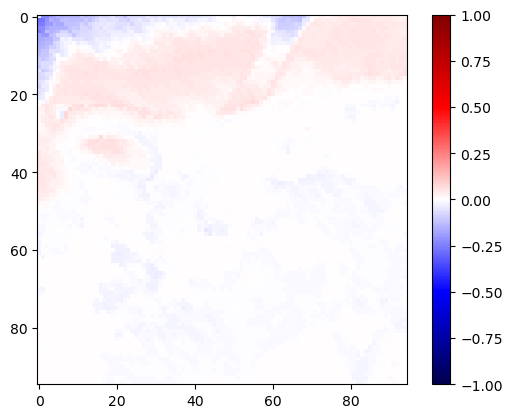

In [174]:
i = 2
plt.imshow( np.reshape((S_samson[0] - S_pred[0]).detach().numpy(), [3,95,95])[i] , cmap='seismic', vmin=-1, vmax=1)
plt.colorbar()

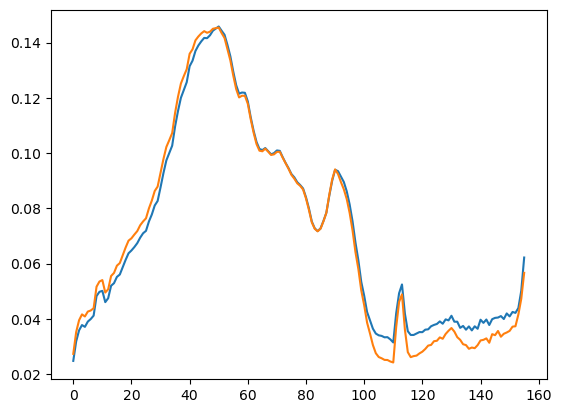

In [178]:
#plt.figure(figsize=(8,5))
i=2
#A_samson
plt.plot(A_samson_normalized[0,:,i].detach().numpy()) #blue 
#A_estimé
plt.plot(A_pred[0,:,i].detach().numpy()) 
#A_snpa
#plt.plot(A_snpa[:,i])

In [ ]:
# Evaluation sur le jeu de données réaliste:

In [179]:
#Chargement d'un jeu de données réaliste
noise_level = 30
N = np.random.randn(X_samson_normalized[0].shape[0],X_samson_normalized[0].shape[1])
N = 10.**(-noise_level/20.)*np.linalg.norm(X_samson_normalized[0])/np.linalg.norm(N)*N
N = torch.reshape(torch.tensor(N), [1,156,9025])
S_realistic = S_samson
A_realistic = A_samson_normalized
X_realistic = A_realistic@S_realistic + N

#Normalisation du X: (Comme à l'entrainement:)
for k in range(9025):
    X_realistic[0][:,k] = X_realistic[0][:,k]/np.linalg.norm(X_realistic[0][:,k])

S_pred, A_pred, S_s, A_s = model(X_realistic) 

In [180]:
#Estimated S
np.round(S_pred[0].detach().numpy(),3)

array([[0.006, 0.001, 0.003, ..., 0.889, 0.931, 0.952],
       [0.   , 0.   , 0.   , ..., 0.021, 0.   , 0.   ],
       [0.999, 0.997, 0.999, ..., 0.089, 0.068, 0.057]])

In [181]:
#Original S
np.round(S_realistic[0].detach().numpy(), 3)

array([[0.   , 0.   , 0.   , ..., 0.912, 0.932, 0.942],
       [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
       [1.   , 1.   , 1.   , ..., 0.088, 0.068, 0.058]])

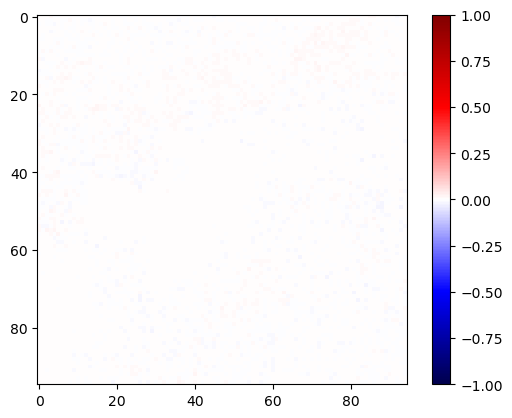

In [182]:
i = 2
plt.imshow( np.reshape((S_realistic[0] - S_pred[0]).detach().numpy(), [3,95,95])[i] , cmap='seismic', vmin=-1, vmax=1)
plt.colorbar()

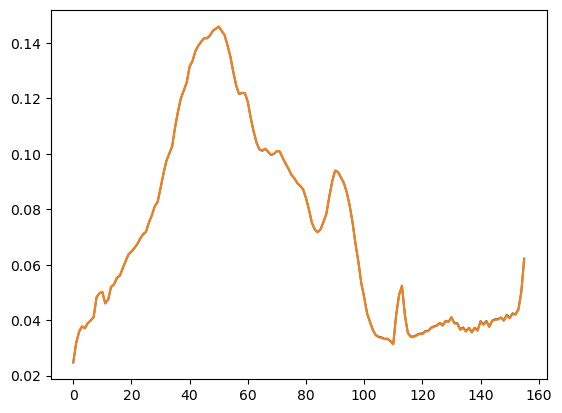

In [33]:
#plt.figure(figsize=(8,5))
i=2
#A_samson
plt.plot(A_realistic[0,:,i].detach().numpy()) #blue 
#A_estimé
plt.plot(A_pred[0,:,i].detach().numpy()) 
#A_snpa
#plt.plot(A_snpa[:,i])

In [ ]:
#D'abord, on remarque que le LPALM ne fonctionne pas sur le jeu réel, toujours le même problème d'échelle.
#A quoi serait-il dû? mauvaise modélisation par Dirichlet ou variabilité spectrale?

#Si il marche plutôt bien sur le jeu réaliste, c'est que peut-être la modélisation par Dirichlet n'est pas très bonne.
#A présent, regardons si l'on peut modifier la modélisation par Dirichlet par l'estimation de SNPA,
#=> Si cela marche, on pourra continuer à créuser du côté des spectres et de la variabilité.

In [ ]:
#Evaluation sur le jeu de données d'entrainement:

In [34]:
#Test sur les données d'entrainement
k = 10
S_realistic = torch.tensor(np.reshape(train_set[k][2], (1,3,9025)))
A_realistic = torch.tensor(np.reshape(train_set[k][1], (1,156,3)))
X_realistic = torch.tensor(np.reshape(train_set[k][0], (1,156,9025)))
S_pred, A_pred, S_s, A_s = model(X_realistic) 

In [35]:
np.round(S_pred[0].detach().numpy(),3)

array([[0.   , 0.   , 0.   , ..., 0.917, 0.922, 0.943],
       [0.   , 0.   , 0.   , ..., 0.   , 0.008, 0.   ],
       [1.005, 1.004, 1.002, ..., 0.078, 0.066, 0.058]])

In [36]:
np.round(S_realistic[0].detach().numpy(), 3)

array([[0.   , 0.   , 0.   , ..., 0.912, 0.932, 0.942],
       [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
       [1.   , 1.   , 1.   , ..., 0.088, 0.068, 0.058]])

In [398]:
#i = 1
#plt.imshow( np.reshape((S_realistic[0]).detach().numpy(), [3,95,95])[i] , cmap='seismic', vmin=-1, vmax=1)
#plt.colorbar()

In [399]:
#plt.imshow( np.reshape((S_pred[0]).detach().numpy(), [3,95,95])[i] , cmap='seismic', vmin=-1, vmax=1)
#plt.colorbar()

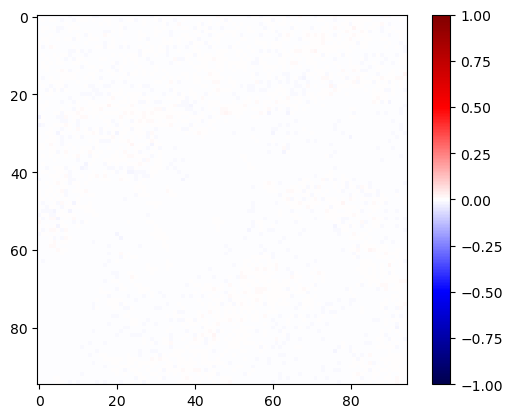

In [39]:
i = 2
plt.imshow( np.reshape((S_realistic[0] - S_pred[0]).detach().numpy(), [3,95,95])[i] , cmap='seismic', vmin=-1, vmax=1)
plt.colorbar()

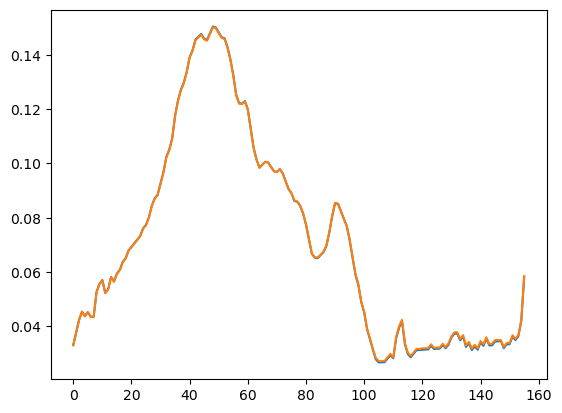

In [42]:
#plt.figure(figsize=(8,5))
i=2
#A_samson
plt.plot(A_realistic[0,:,i].detach().numpy()) #blue 
#A_estimé
plt.plot(A_pred[0,:,i].detach().numpy()) 

In [ ]:
#Test sur les A d'entrainements couplés au S de ground truth

In [43]:
#Test sur les données d'entrainement
noise_level = 30
N = np.random.randn(X_samson_normalized[0].shape[0],X_samson_normalized[0].shape[1])
N = 10.**(-noise_level/20.)*np.linalg.norm(X_samson_normalized[0])/np.linalg.norm(N)*N
N = torch.reshape(torch.tensor(N), [1,156,9025])

k = 10
#S_realistic = torch.tensor(np.reshape(S_snpa, (1,3,9025)))

S_realistic = S_samson

A_realistic = torch.tensor(np.reshape(train_set[k][1], (1,156,3)))
X_realistic = A_realistic@S_realistic + N

for c in range(9025):
    X_realistic[0][:,c] = X_realistic[0][:,c]/np.linalg.norm(X_realistic[0][:,c])

S_pred, A_pred, S_s, A_s = model(X_realistic) 

In [44]:
np.round(S_pred[0].detach().numpy(),3)

array([[0.   , 0.   , 0.   , ..., 0.907, 0.925, 0.94 ],
       [0.   , 0.008, 0.   , ..., 0.002, 0.009, 0.   ],
       [0.998, 1.   , 1.003, ..., 0.084, 0.062, 0.059]])

In [45]:
np.round(S_realistic[0].detach().numpy(), 3)

array([[0.   , 0.   , 0.   , ..., 0.912, 0.932, 0.942],
       [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
       [1.   , 1.   , 1.   , ..., 0.088, 0.068, 0.058]])

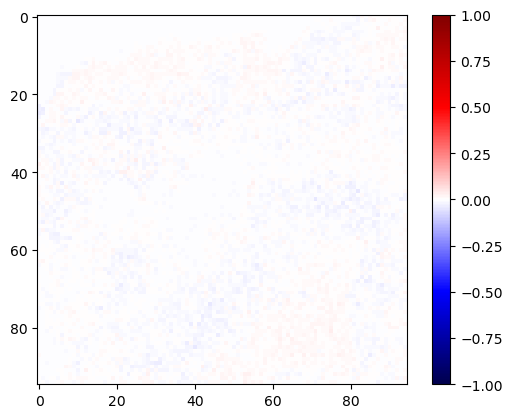

In [48]:
i = 0
plt.imshow( np.reshape((S_realistic[0] - S_pred[0]).detach().numpy(), [3,95,95])[i] , cmap='seismic', vmin=-1, vmax=1)
plt.colorbar()

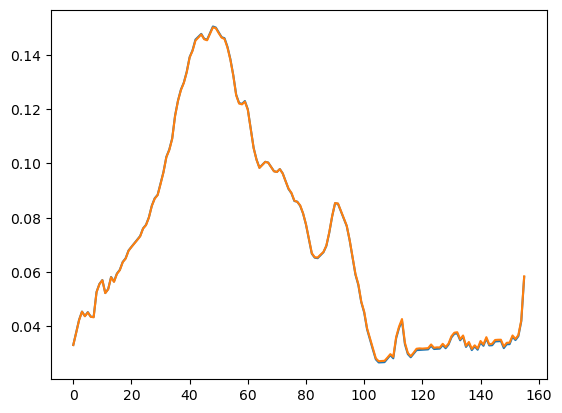

In [51]:
#plt.figure(figsize=(8,5))
i=2
#A_samson
plt.plot(A_realistic[0,:,i].detach().numpy()) #blue 
#A_estimé
plt.plot(A_pred[0,:,i].detach().numpy()) 

In [ ]:
#Test sur les samples d'entrainement issus du LPALM_ReLU

In [128]:
k = 18

S_realistic = torch.tensor(np.reshape(train_set_1[k][2], (1,3,9025)))
A_realistic = torch.tensor(np.reshape(train_set_1[k][1], (1,156,3)))
X_realistic = torch.tensor(np.reshape(train_set_1[k][0], (1,156,9025)))

S_pred, A_pred, S_s, A_s = model(X_realistic) 

In [129]:
np.round(S_pred[0].detach().numpy(),3)

array([[0.   , 0.   , 0.   , ..., 0.796, 0.85 , 0.769],
       [1.172, 1.181, 1.176, ..., 0.   , 0.   , 0.   ],
       [0.389, 0.254, 0.233, ..., 0.835, 0.692, 0.9  ]])

In [130]:
np.round(S_realistic[0].detach().numpy(), 3)

array([[0.002, 0.01 , 0.006, ..., 0.364, 0.446, 0.333],
       [0.907, 0.966, 0.978, ..., 0.006, 0.002, 0.   ],
       [0.091, 0.024, 0.015, ..., 0.63 , 0.552, 0.667]])

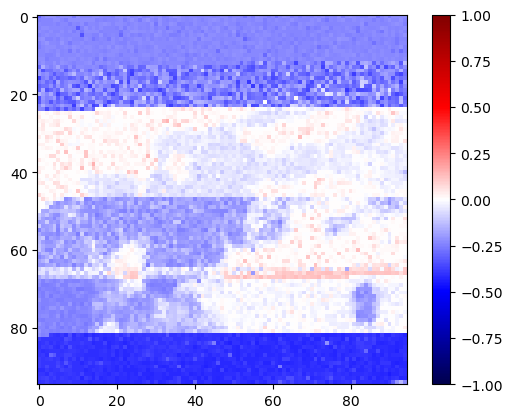

In [147]:
i = 2
plt.imshow( np.reshape((S_realistic[0] - S_pred[0]).detach().numpy(), [3,95,95])[i] , cmap='seismic', vmin=-1, vmax=1)
plt.colorbar()

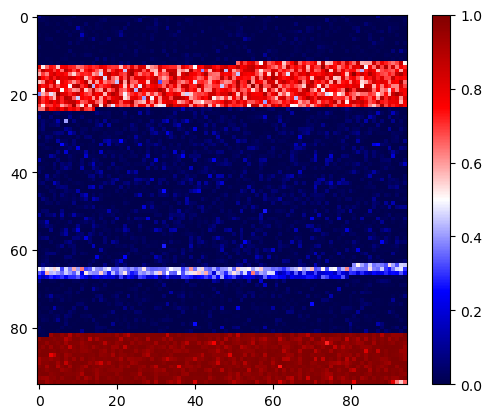

In [153]:
i = 2
plt.imshow( np.reshape((S_realistic[0]).detach().numpy(), [3,95,95])[i] , cmap='seismic', vmin=0, vmax=1)
plt.colorbar()

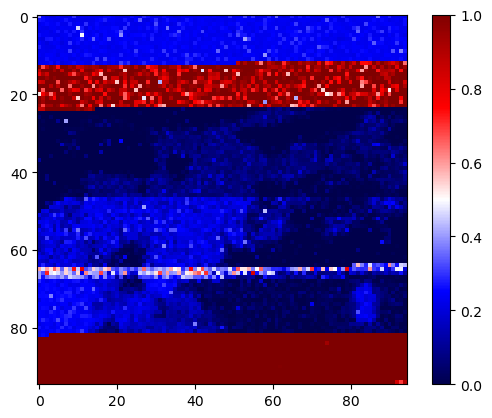

In [154]:
plt.imshow( np.reshape((S_pred[0]).detach().numpy(), [3,95,95])[i] , cmap='seismic', vmin=0, vmax=1)
plt.colorbar()

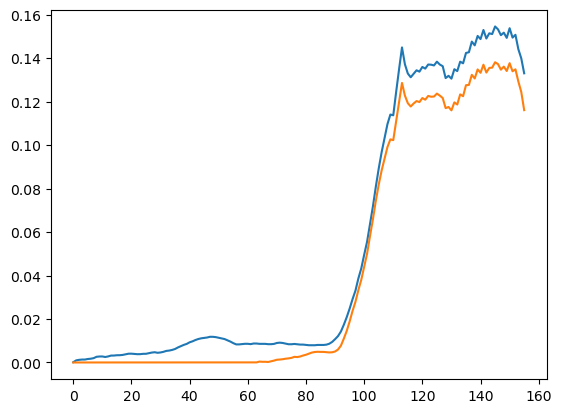

In [155]:
#plt.figure(figsize=(8,5))
i=1
#A_samson
plt.plot(A_realistic[0,:,i].detach().numpy()) #blue 
#A_estimé
plt.plot(A_pred[0,:,i].detach().numpy()) 

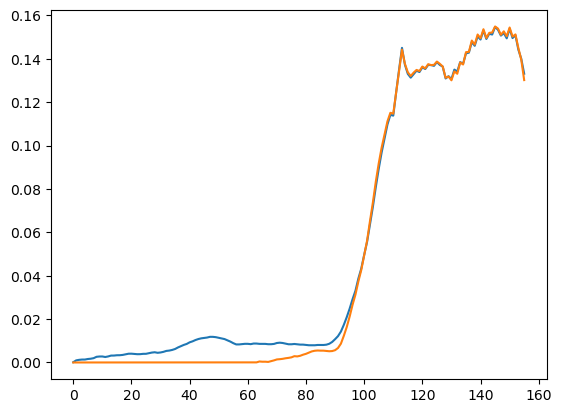

In [156]:
i=1
plt.plot(A_realistic[0,:,i].detach().numpy()) #blue 
plt.plot(A_pred[0][:,i].detach().numpy()/np.linalg.norm(A_pred[0][:,1].detach().numpy()))

#### 2.1 Evaluation qualitative

##### Evaluation du S: Comparaison des valeurs des S (original/estimé)

In [176]:
S_samson

tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.9122, 0.9325, 0.9417],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [1.0000, 1.0000, 1.0000,  ..., 0.0878, 0.0675, 0.0583]]],
       dtype=torch.float64)

In [177]:
np.round(S_pred[0].detach().numpy(),4)

array([[0.1503, 0.1503, 0.1503, ..., 0.9581, 0.972 , 0.9778],
       [0.    , 0.    , 0.    , ..., 0.    , 0.    , 0.    ],
       [0.8646, 0.8645, 0.8645, ..., 0.022 , 0.    , 0.    ]])

In [178]:
torch.sum(S_pred[0], dim=0)

tensor([1.0149, 1.0149, 1.0149,  ..., 0.9801, 0.9720, 0.9778],
       dtype=torch.float64, grad_fn=<SumBackward1>)

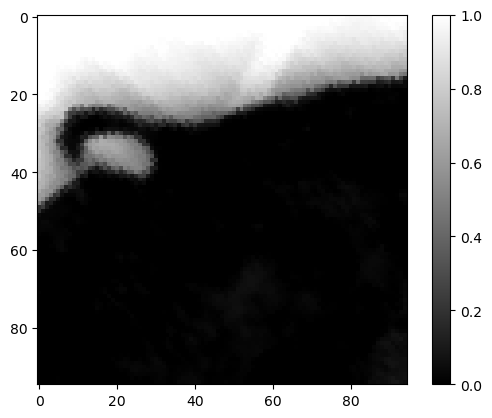

In [179]:
#Affichage des carte d'abondance
#S_samson
i=2
plt.imshow(S_samson.reshape([3,95,95])[i],vmin=0, vmax=1, cmap='gray')
plt.colorbar()

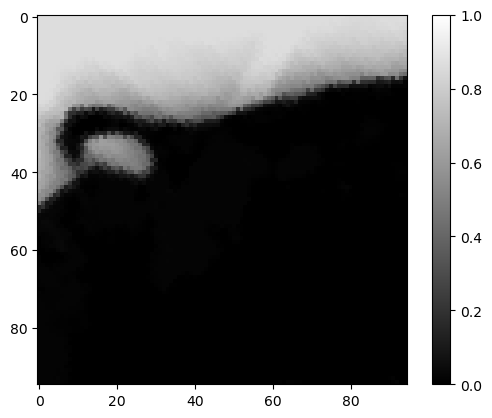

In [180]:
#S estimé
S_i = np.reshape((S_pred[0][i]).detach().numpy(),(95,95)) #ajout d'une ReLU
plt.imshow(S_i,vmin=0, vmax=1,cmap='gray')
plt.colorbar()

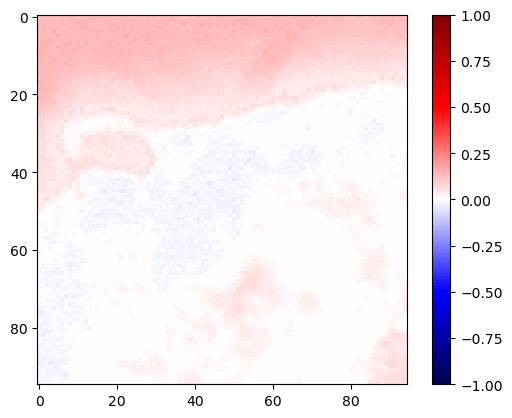

In [244]:
i = 2
plt.imshow( np.reshape(S_samson - S_pred[0].detach().numpy(), [3,95,95])[i] , cmap='seismic', vmin=-1, vmax=1)
plt.colorbar()

##### Evaluation du A: visualisation des A (original/estimé)

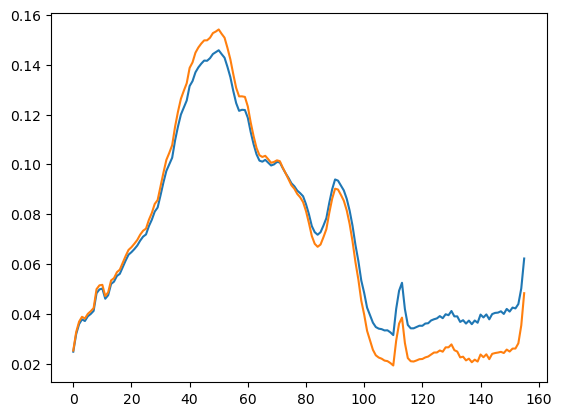

In [165]:
#plt.figure(figsize=(8,5))
i=2
#A_jasper
plt.plot((A_samson_normalized[0,:,i]).detach().numpy()) #blue 
#A_estimé
plt.plot(A_pred[0,:,i].detach().numpy()) #orange
#A_snpa
#plt.plot(A_snpa[:,i]) #orange

In [156]:
i = 0
#np.linalg.norm(A_pred[0,:,i].detach().numpy())
np.linalg.norm(A_samson_normalized[0,:,i].detach().numpy())

1.0

#### 2.2 Evaluation quantitative

##### Fonctions pour le calcul des erreurs sur les matrices ligne/ligne et colonne/colonne

In [156]:
def Single_SME(A_est, A_star, i):
    #A_est: estimated A | ndarray format
    #A_star: ground truth A | ndarray format
    #i: the column of the matrix A
    
    score = (A_star[:,i] - A_est[:,i])@(A_star[:,i] - A_est[:,i])
    return score/ (np.linalg.norm(A_star[:,i], ord=None))**2

In [157]:
def Single_AME(S_est, S_star, i):
    #S_est: estimated S | ndarray format
    #S_star: ground truth S | ndarray format
    #i: the lign of the matrix S
    
    score = (S_star[i,:] - S_est[i,:])@(S_star[i,:] - S_est[i,:])
    return score/ (S_star[i,:]@S_star[i,:])

##### Fonctions pour le calcul des erreurs sur les matrices entières

In [158]:
def Spectral_ME(A_est, A_star): #Normalisée
    
    score = (np.linalg.norm(A_star - A_est, ord=None))**2
    return score / (np.linalg.norm(A_star, ord=None)**2)

In [159]:
def Abundance_ME(S_est, S_star): #Normalisée
    
    score = (np.linalg.norm(S_star - S_est, ord=None))**2
    return score / (np.linalg.norm(S_star, ord=None)**2)

#### D'abord une évaluation détaillée colonne/colonne de A et ligne/ligne de S

In [160]:
#A choisir selon les différents scénarii
A_star = A_samson_normalized[0].detach().numpy()
S_star = np.asarray(S_samson[0])
A_predi = A_pred[0].detach().numpy()
S_predi = S_pred[0].detach().numpy()

In [161]:
i = 0
#Spectral evaluation
SSME_LPALM = Single_SME(A_star, A_predi, i)
#Abundance evaluation
SAME_LPALM = Single_AME(S_star, S_predi, i)

print(f"SAME_LPALM for EM {i+1} is :{SAME_LPALM:.7f}, log_SAME_LPALM for EM {i+1} is:{-10*np.log10(SAME_LPALM):.7f} dB")
print(f"SSME_LPALM for EM {i+1} is :{SSME_LPALM:.7f}, log_SSME_LPALM for EM {i+1} is:{-10*np.log10(SSME_LPALM):.7f} dB")

SAME_LPALM for EM 1 is :1.9263149, log_SAME_LPALM for EM 1 is:-2.8472729 dB
SSME_LPALM for EM 1 is :0.0080753, log_SSME_LPALM for EM 1 is:20.9283867 dB


#### Puis une évaluation groupée (sur l'ensemble de la matrice)

In [162]:
#Spectral evaluation
AME_LPALM = Abundance_ME(S_star, S_predi)
log_AME_LPALM = -10*np.log10(AME_LPALM)#Valeur en dB (decibel)

#Abundance evaluation
SME_LPALM = Spectral_ME(A_star, A_predi)
log_SME_LPALM = -10*np.log10(SME_LPALM) #Valeur en dB (decibel)

print(f"AME_LPALM is :{AME_LPALM:.7f}, log_AME_LPALM is :{log_AME_LPALM:.7f} dB")
print(f"SME_LPALM is :{SME_LPALM:.7f}, log_SME_LPALM is :{log_SME_LPALM:.7f} dB")

AME_LPALM is :1.5254403, log_AME_LPALM is :-1.8339521 dB
SME_LPALM is :0.6099957, log_SME_LPALM is :2.1467323 dB


### 3. Evaluation du PALM

#### Définition du PALM

In [176]:
def PALM(X, Ainit, n, lamb, nbIt):
    
    #X: image to be unmixed |ndarray format expected
    #Ainit: Initializing A (chosen from the train set) |ndarray format expected
    #n: the number of expected materials/spectra
    #lamb: the soft-thresholding parameter
    #nbIt: the number of iterations
    
    eps = 0.01 #Constant value to avoid dividing by zero
    
    S_iter = [] #To stock the iteration results
    A_iter = []
    
    A_est = Ainit.copy() #Initializing our estimates
    S_est = np.dot(np.linalg.pinv(A_est),X)

    for i in range(nbIt):
        # S update
        gamma = 1./((np.linalg.norm(A_est,ord=2)**2)*(1.+eps))
        S_est = S_est + gamma*np.dot(A_est.T,(X - A_est@S_est))
        S_est = prox_l1(S_est,lamb*gamma)
    
        # A update 
        eta = 1./((np.linalg.norm(S_est,ord=2)**2) *(1+eps))
        A_est = A_est + eta*(X - A_est@S_est)@S_est.T
        
        A_est = A_est*(A_est>0) #Projection sur l'orthant non-négatif
        A_est = prox_oblique(A_est) #Projection oblique
    
    return S_est, A_est, S_iter, A_iter

#### A la recherche des matrices d'initialisation du PALM

In [177]:
# D'abord, trouver les jeux de données les plus proche et eloigné de la GT:

#a) Jeu de référence: (On prend la ground truth)
A0 = np.asarray(A_samson_normalized[0])

#b) Calcul des distances entre les samples du jeu d'entrainement et la ground truth (pour le choix de l'init)
l = []

for j,(X,A,S) in enumerate(train_set): #val_set): #
    for i in range(3):
        A[:,i] = A[:,i]/(np.linalg.norm(A[:,i],ord=2))
    
    crit = np.sum(np.multiply(A0[:,0],A[:,0])) / (np.linalg.norm(A0[:,0]) * np.linalg.norm(A[:,0])) + np.sum(np.multiply(A0[:,1],A[:,1])) / (np.linalg.norm(A0[:,1]) * np.linalg.norm(A[:,1])) + np.sum(np.multiply(A0[:,2],A[:,2])) / (np.linalg.norm(A0[:,2]) * np.linalg.norm(A[:,2]))
    l.append(crit)

In [178]:
print(f"Max distance : {max(l)}, it correspond to the index :{np.where(l == max(l))[0]}")
print(f"Min distance : {min(l)}, it correspond to the index :{np.where(l == min(l))[0]}")

Max distance : 1.8084274503803204, it correspond to the index :[47]
Min distance : 1.7029141854645704, it correspond to the index :[109]


Comme c'est un ratio (distance angulaire), le jeu le plus éloigné sera le jeu dont le ratio est le plus petit.

##### Exécution du PALM

In [393]:
#On peut evaleur selon différents scénarios (jeu synthétique / réaliste / réel)
X_init = np.asarray(X_samson_normalized[0]) #np.reshape(np.asarray(A_jasper_norm@S_jasper),(198,10000))#np.reshape(np.asarray(val_set[0][0]),(198, 10000))

X = X_init
Ainit = np.asarray(train_set[109][1]) #A choisir

In [394]:
n=3 #Il y a 4 spectres dans Jasper
lamb = 0.1 #0.05 le meilleur à priori, 0.1 très bon, 0.2 reste bon /!\ Important /!\
nbIt = 25 #00#0e0

S_est, A_est, S_iter, A_iter = PALM(X, Ainit, n, lamb, nbIt)

AttributeError: 'int' object has no attribute 'copy'

#### 3.1 Evaluation qualitative (Avec comparaison au LPALM)

##### Evaluation des cartes d'abondance

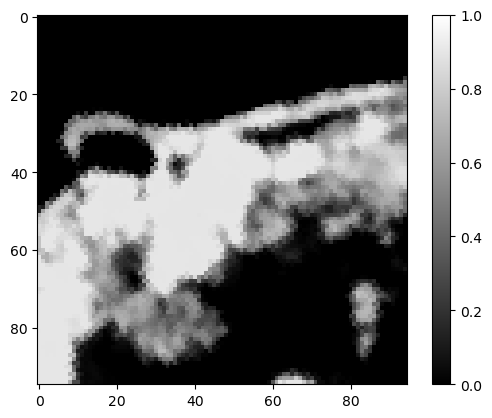

In [197]:
i = 2
plt.imshow(S_est.reshape([3,95,95])[i],vmin=0, vmax=1,cmap='gray')
plt.colorbar()

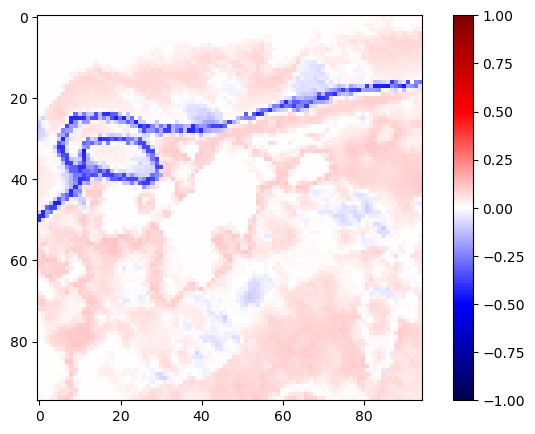

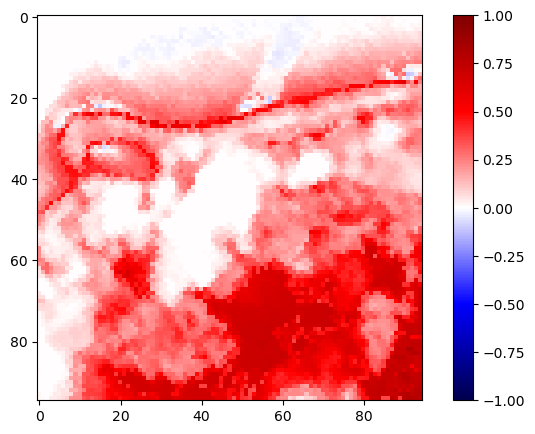

In [191]:
#Comparaison des différences entre les cartes d'abondance prédites: (PALM/LPALM)
i = 0

img1 = S_samson.reshape([3,95,95])[i].detach().numpy() - S_est.reshape([3,95,95])[i] #PALM
img2 = S_samson.reshape([3,95,95])[i].detach().numpy() - np.reshape((S_pred[0][i]).detach().numpy(),(95,95)) #LPALM

images = [img1, img2]

for file in images:
    plt.figure(figsize=(8,5))
    plt.imshow(file,cmap='seismic', vmin=-1, vmax=1)
    plt.colorbar()
    plt.show()

##### Evaluation des spectres

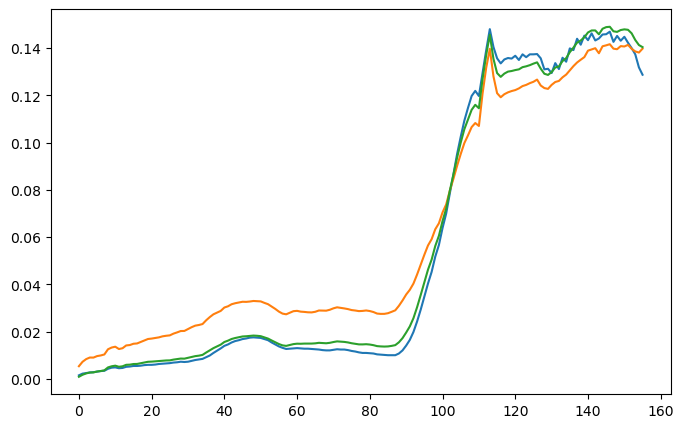

In [206]:
i=1
j=2
plt.figure(figsize=(8,5))
plt.plot(A_samson_normalized[0][:,i]) #Ground truth (Blue)
plt.plot(A_pred[0].detach().numpy()[:,j]) #LPALM (Orange)
plt.plot(A_est[:,j])#PALM (Green)


##### 3.2 Evaluation quantitative

##### Evaluation détaillée des résultats d'estimation ligne/ligne et colonne/colonne

In [210]:
#A choisir !
A_star = A_samson_normalized[0].detach().numpy()
S_star = np.asarray(S_samson[0])

i = 3
#Spectral evaluation
SSME_PALM = Single_SME(A_star, A_est, i)
#Abundance Evaluation
SAME_PALM = Single_AME(S_star, S_est, i)

print(f"SSME_PALM for EM {i+1} is: {SSME_PALM:.7f}, log_SSME_PALM for EM {i+1} is: {-10*np.log10(SSME_PALM):.7f} dB}")
print(f"SAME_PALM for EM {i+1} is: {SAME_PALM:.7f}, log_SAME_PALM for EM {i+1} is: {-10*np.log10(SAME_PALM):.7f} dB}")

SyntaxError: f-string: single '}' is not allowed (3295841186.py, line 12)

##### Evaluation globale des résultats d'estimation

In [211]:
#Spectral evaluation
SME_PALM = Spectral_ME(A_star, A_est)
log_SME_PALM = -10*np.log10(SME_PALM)#Valeur en dB (decibel)

#Abundance evaluation
AME_PALM = Abundance_ME(S_star, S_est)
log_AME_PALM = -10*np.log10(AME_PALM) #Valeur en dB (decibel)

print(f"AME_PALM is: {AME_PALM:.7f}, log_AME_PALM is: {log_AME_PALM:.7f} dB")
print(f"SME_PALM is: {SME_PALM:.7f}, log_SME_PALM is: {log_SME_PALM:.7f} dB")

AME_PALM is: 1.3309252, log_AME_PALM is: -1.2415364 dB
SME_PALM is: 0.7671238, log_SME_PALM is: 1.1513455 dB


### 4. Evaluation du PALM modifié.

In [212]:
#Fonction ReLU pour le PALM
def prox_relu(S_est,thrd): #numpy
  S_est[(S_est <= thrd)] = 0
  indNZ = np.where(S_est > thrd)[0]
  S_est[indNZ] = S_est[indNZ] - thrd*np.sign(S_est[indNZ])
  return S_est

#f) Evaluation du PALM modifié pour différentes valeurs de lambda (Choix en fonction de la métrique)
X = np.reshape(np.asarray(X_jasper_norm),(198, 10000))
n=4
lamb=0.1
nbIt = 200#0e0
eps = 0.01 

#S_int = [] #To memorize the result at each iteration
#A_int = []

#Matrices où l'on va stocker Les A et S estimés
A_tmp_1 = np.zeros((198,4)) 
S_tmp_1 = np.zeros((4,10000))

for k in [0,80,159]: #range(np.shape(train_set)[0]):
    Ainit = train_set[k][1] #val_set[0][1] #
    A_est_1 = Ainit.copy() #init_A_est
    S_est_1 = np.dot(np.linalg.pinv(A_est_1),X) #init_S_est    
        
    for i in range(nbIt):
        # S update
        gamma = 1./((np.linalg.norm(A_est_1,ord=2)**2)*(1.+eps))
        S_est_1 = S_est_1 + gamma*np.dot(A_est_1.T,(X - A_est_1@S_est_1))
    
        #On remplace Par une ReLU
        S_est_1 = prox_relu(S_est_1,lamb*gamma) #ReLU
        for j in range(np.shape(S_jasper)[1]): #Simplexe
            S_est_1[:,j] /= np.sum(S_est_1[:,j])
    
        # A update 
        eta = 1./((np.linalg.norm(S_est_1,ord=2)**2) *(1+eps))
        A_est_1 = A_est_1 + eta*(X - A_est_1@S_est_1)@S_est_1.T

        A_est_1 = A_est_1*(A_est_1>0) #Non-negative orthant projection
        A_est_1 = prox_oblique(A_est_1) #Projection on the unit ball
    
    A_tmp_1 += A_est_1
    S_tmp_1 += S_est_1
    
    if k != 0:
        A_tmp_1 = A_tmp_1*0.5
        S_tmp_1 = S_tmp_1*0.5
    
        #S_int.append(S_est)
        #A_int.append(A_est)
        #Loss.append(Spectral_ME(A_est,A_jasper_norm) + Abundance_ME(S_est, S_jasper))

In [218]:
def PALM_modif(X, Ainit, n, lamb, nbIt):
    
    #X: image to be unmixed |ndarray format expected
    #Ainit: Initializing A (chosen from the train set) |ndarray format expected
    #n: the number of expected materials/spectra
    #lamb: the soft-thresholding parameter
    #nbIt: the number of iterations
    
    eps = 0.01 #Constant value to avoid dividing by zero
    
    S_iter = [] #To stock the iteration results
    A_iter = []
    
    A_est = Ainit.copy() #Initializing our estimates
    S_est = np.dot(np.linalg.pinv(A_est),X)

    for i in range(nbIt):
        # S update
        gamma = 1./((np.linalg.norm(A_est,ord=2)**2)*(1.+eps))
        S_est = S_est + gamma*np.dot(A_est.T,(X - A_est@S_est))
    
        #On remplace Par une ReLU
        S_est = prox_relu(S_est,lamb*gamma) #ReLU
        for j in range(np.shape(S_samson)[1]): #Simplexe
            S_est[:,j] /= np.sum(S_est[:,j])
    
        # A update 
        eta = 1./((np.linalg.norm(S_est,ord=2)**2) *(1+eps))
        A_est = A_est + eta*(X - A_est@S_est)@S_est.T
        
        A_est = A_est*(A_est>0) #Projection sur l'orthant non-négatif
        A_est = prox_oblique(A_est) #Projection oblique
    
    return S_est, A_est, S_iter, A_iter

In [219]:
#On peut evaleur selon différents scénarios (jeu synthétique / réaliste / réel)
X_init = np.asarray(X_samson_normalized[0]) #np.reshape(np.asarray(A_jasper_norm@S_jasper),(198,10000))#np.reshape(np.asarray(val_set[0][0]),(198, 10000))

X = X_init
Ainit = np.asarray(train_set[109][1]) #A choisir

n=3 #Il y a 4 spectres dans Jasper
lamb = 0.1 #0.05 le meilleur à priori, 0.1 très bon, 0.2 reste bon /!\ Important /!\
nbIt = 200#0e0

S_est_modif, A_est_modif, S_iter_modif, A_iter_modif = PALM_modif(X, Ainit, n, lamb, nbIt)

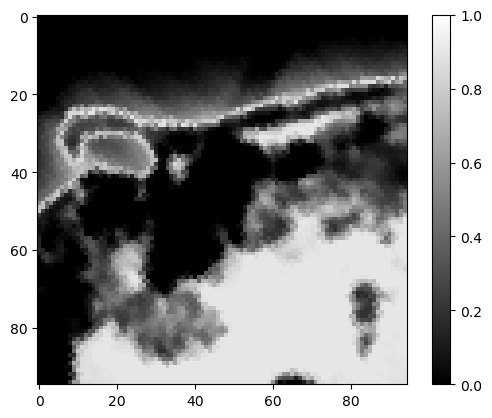

In [222]:
i = 0
plt.imshow(S_est_modif.reshape([3,95,95])[i],vmin=0, vmax=1,cmap='gray')
plt.colorbar()

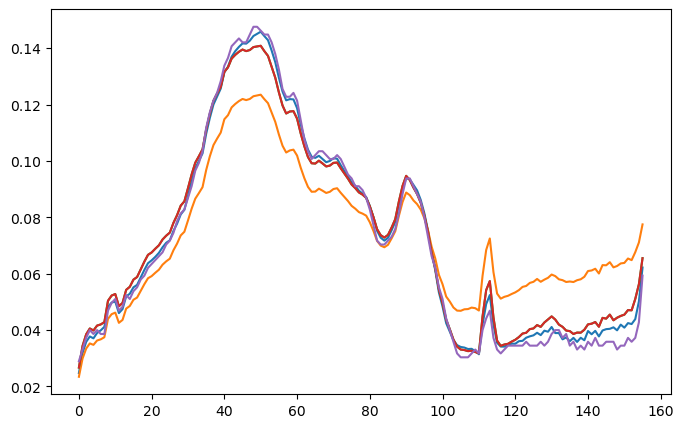

In [240]:
i=2
j=1
plt.figure(figsize=(8,5))
plt.plot(A_samson_normalized[0][:,i]) #Ground truth (Blue)
plt.plot(A_pred[0].detach().numpy()[:,j]) #LPALM (Orange)
plt.plot(A_est[:,j])#PALM (Green)
plt.plot(A_est_modif[:,j])#PALM_modif (Green)
plt.plot(A1_snpa) #(Violet)


In [ ]:
PALM_modif(X, Ainit, n, lamb, nbIt)aa

In [333]:
A_est_1 = A_tmp_1
S_est_1 = S_tmp_1

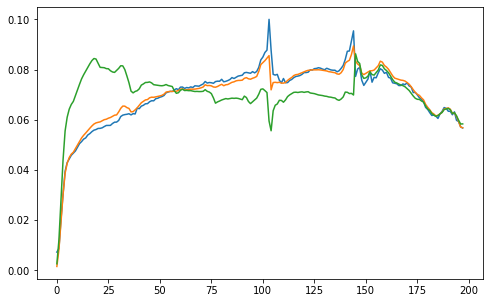

In [397]:
i=3
#PALM
plt.figure(figsize=(8,5))
plt.plot(A_jasper_norm[0][:,i]) #Ground truth (Blue)
plt.plot(A_est_1[:,i])#Modified_PALM (Orange)
plt.plot(A_pred[0].detach().numpy()[:,i]) #LPALM (Green)

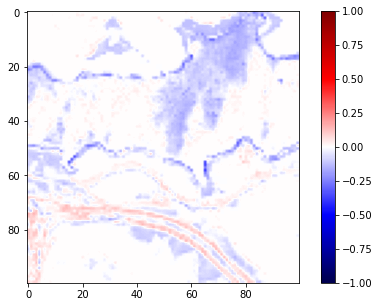

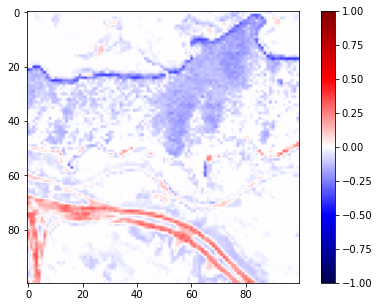

In [401]:
#Comparaison des cartes d'abondance prédites:
i = 3

img1 = S_jasper.reshape([4,100,100])[i].detach().numpy() - S_est_1.reshape([4,100,100])[i] #PALM modifié
img2 = S_jasper.reshape([4,100,100])[i].detach().numpy() - np.reshape((S_pred[0][i]).detach().numpy(),(100,100)) #LPALM

images = [img1, img2]

for file in images:
    plt.figure(figsize=(8,5))
    plt.imshow(file,cmap='seismic', vmin=-1, vmax=1)
    plt.colorbar()
    plt.show()

##### Evaluation détaillée

In [560]:
#Spectral evaluation
i = 3
SSME_PALM_1 = Single_SME(A_jasper_norm[0].detach().numpy(), A_est_1, i)
SSME_LPALM = Single_SME(A_jasper_norm[0].detach().numpy(), A_pred[0].detach().numpy(), i)

print(f"SSME_PALM for EM {i+1} is: {SSME_PALM_1}, SSME_LPALM for EM {i+1} is :{SSME_LPALM}")
print(f"log_SSME_PALM for EM {i+1} is: {-10*np.log10(SSME_PALM_1)} dB, log_SSME_LPALM for EM {i+1} is:{-10*np.log10(SSME_LPALM)} dB")

SSME_PALM for EM 4 is: 0.0012083810007351714, SSME_LPALM for EM 4 is :0.02829745078393494
log_SSME_PALM for EM 4 is: 29.17796111717809 dB, log_SSME_LPALM for EM 4 is:15.48252686749086 dB


In [509]:
#Abundance evaluation
i = 3
SAME_PALM_1 = Single_AME(np.asarray(S_jasper[0]), S_est_1, i)
SAME_LPALM = Single_AME(np.asarray(S_jasper[0]), S_pred[0].detach().numpy(), i)

print(f"SAME_PALM for EM {i+1} is: {SAME_PALM_1}, SAME_LPALM for EM {i+1} is :{SAME_LPALM}")
print(f"log_SAME_PALM for EM {i+1} is: {-10*np.log10(SAME_PALM_1)} dB, log_SAME_LPALM for EM {i+1} is:{-10*np.log10(SAME_LPALM)} dB")

SAME_PALM for EM 4 is: 0.051851826770837994, SAME_LPALM for EM 4 is :0.15276430779671718
log_SAME_PALM for EM 4 is: 12.852359385513285 dB, log_SAME_LPALM for EM 4 is:8.159781034673168 dB


#### Evaluation globale

In [510]:
#Affichage des scores de comparaison à la ground truth PALM vs LPALM

AME_PALM_1 = Abundance_ME(np.asarray(S_jasper[0]), S_est_1)
log_AME_PALM_1 = -10*np.log10(AME_PALM_1) #Valeur en dB (decibel)

AME_LPALM = Abundance_ME(np.asarray(S_jasper[0]), S_pred[0].detach().numpy())
log_AME_LPALM = -10*np.log10(AME_LPALM)#Valeur en dB (decibel)

print(f"AME_PALM is: {AME_PALM_1}, AME_LPALM is :{AME_LPALM}")
print(f"log_AME_PALM is: {log_AME_PALM_1} dB, log_AME_LPALM is :{log_AME_LPALM} dB")

AME_PALM is: 0.03758489913113279, AME_LPALM is :0.028792076129062025
log_AME_PALM is: 14.249866109586923 dB, log_AME_LPALM is :15.407270180365899 dB


In [561]:
SME_PALM_1 = Spectral_ME(A_jasper_norm[0].detach().numpy(), A_est_1)
log_SME_PALM_1 = -10*np.log10(SME_PALM_1)#Valeur en dB (decibel)

SME_LPALM = Spectral_ME(A_jasper_norm[0].detach().numpy(), A_pred[0].detach().numpy())
log_SME_LPALM = -10*np.log10(SME_LPALM) #Valeur en dB (decibel)

print(f"SME_PALM is: {SME_PALM_1}, SME_LPALM is :{SME_LPALM}")
print(f"log_SME_PALM is: {log_SME_PALM_1} dB, log_SME_LPALM is :{log_SME_LPALM} dB")

SME_PALM is: 0.0021964180323758285, SME_LPALM is :0.010506706781115028
log_SME_PALM is: 26.582849994330804 dB, log_SME_LPALM is :19.785333877691837 dB


In [430]:
np.shape(S_val.reshape([4,100,100]))

(4, 100, 100)

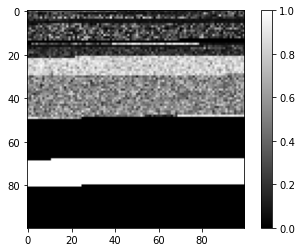

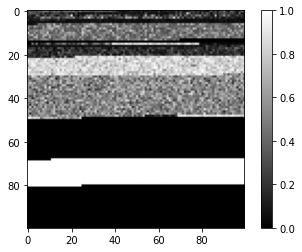

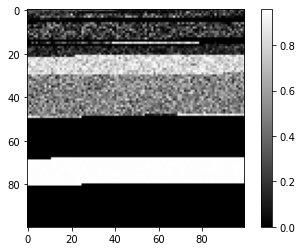

In [453]:
#Comparaison des cartes d'abondance prédites:
# [!] Ne pas oublier de regarder l'ensemble des i, un seul ne signifie rien [!]

i = 0 

img1 = (torch.tensor(S_val)).reshape([4,100,100])[i] #Original
img2 = np.reshape((S_pred[0][i]).detach().numpy(),(100,100)) #LPALM
img3 = S_est.reshape([4,100,100])[i] #PALM

images = [img1, img2, img3]

for file in images:
    plt.imshow(file,cmap='gray')
    plt.colorbar()
    plt.show()

Les cartes d'abondances générées ne sont pas forcément significatives.

In [449]:
#Affichage des scores de comparaison à la ground truth PALM vs LPALM

AME_PALM = Abundance_ME(S_val, S_est)
log_AME_PALM = -10*np.log10(AME_PALM) #Valeur en dB (decibel)

AME_LPALM = Abundance_ME(S_val, S_pred[0].detach().numpy())
log_AME_LPALM = -10*np.log10(AME_LPALM)#Valeur en dB (decibel)

print(f"AME_PALM is: {AME_PALM}, AME_LPALM is :{AME_LPALM}")
print(f"log_AME_PALM is: {log_AME_PALM} dB, log_AME_LPALM is :{log_AME_LPALM} dB")

AME_PALM is: 0.0378570011800967, AME_LPALM is :0.016583711003484852
log_AME_PALM is: 14.218537913896053 dB, log_AME_LPALM is :17.803182790934894 dB


In [450]:
SME_PALM = Spectral_ME(A_val, A_est)
log_SME_PALM = -10*np.log10(SME_PALM)#Valeur en dB (decibel)

SME_LPALM = Spectral_ME(A_val, A_pred[0].detach().numpy())
log_SME_LPALM = -10*np.log10(SME_LPALM) #Valeur en dB (decibel)

print(f"SME_PALM is: {SME_PALM}, SME_LPALM is :{SME_LPALM}")
print(f"log_SME_PALM is: {log_SME_PALM} dB, log_SME_LPALM is :{log_SME_LPALM} dB")

SME_PALM is: 0.0003235558694354138, SME_LPALM is :0.00018654921909290053
log_SME_PALM is: 34.90050717491314 dB, log_SME_LPALM is :37.292065646041436 dB


#### Génération de variabilités spectrales

In [8]:
def affine_piece_wise(c_var,L):
    
    #Fonction qui donne les coordonnées nécessaires à la fct continue par morceaux
    
    #c_var: variability coefficient
    #L: Nummber of channels 
    xi_1 = np.random.uniform(low=1-c_var/2, high=1+c_var/2, size=None)
    xi_2 = np.random.uniform(low=1-c_var/2, high=1+c_var/2, size=None)
    xi_3 = np.random.uniform(low=1-c_var/2, high=1+c_var/2, size=None)
    U = np.random.normal(loc=0.0, scale=1.0, size=None)
    
    if U > 3/2 or U < -1.4: #Après calcul de l'intervalle
        L_break = int(np.floor(L/2))
    else:
        L_break = int( np.floor(L/2 + np.floor(L*U/3)) ) 
    
    return xi_1, xi_2, xi_3, L_break

In [9]:
def perturbated_spectrum(spectrum, c_var, L):
    #Fonction qui à partir des coordonnées de affine_piece_wise, établi la perturbation (produit)
    
    #spectrum: the spectra to which we'll apply the perturbation
    #c_var: variability coefficient
    #L: Nummber of channels
    xi_1, xi_2, xi_3, L_break = affine_piece_wise(c_var,L)
    
    #Calcul des coefficients directeurs et des ordonnées à l'origine des 2 fcts affines 
    a_1 = (xi_2-xi_1)/(L_break-1)
    c_1 = (xi_1-1*a_1)

    a_2 = (xi_3-xi_2)/(L-L_break)
    c_2 = (xi_3-L*a_2)
    
    #Calcul de la perturbation
    perturbation = [i for i in range(1,L+1)]
    
    for i in range(L_break):
        perturbation[i] = a_1*(i+1) + c_1
    for i in range(L_break,L):
        perturbation[i] = a_2*(i+1) + c_2
    
    #Application de la perturbation
    spectrum_modified = (spectrum.clone()).detach().numpy() # spectrum.copy() #Dépend de l'utilisation
    
    for i in range(L):
        spectrum_modified[i] = spectrum_modified[i]*perturbation[i]
        
    #Normalisation de ces spectres dans la boule L2 (sphère)
    if sum(spectrum_modified*spectrum_modified) > 1:
        spectrum_modified /= np.linalg.norm(spectrum_modified)
        
    return spectrum_modified

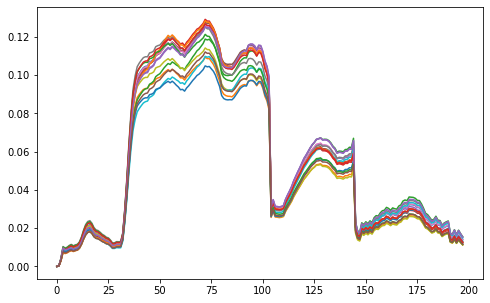

In [66]:
i = 0
L=198
c_var = 0.4
spectrum = A_jasper_norm[0,:,i]
spec1 = perturbated_spectrum(spectrum, c_var, L)
spec2 = perturbated_spectrum(spectrum, c_var, L)
spec3 = perturbated_spectrum(spectrum, c_var, L)
spec4 = perturbated_spectrum(spectrum, c_var, L)
spec5 = perturbated_spectrum(spectrum, c_var, L)
spec6 = perturbated_spectrum(spectrum, c_var, L)
spec7 = perturbated_spectrum(spectrum, c_var, L)
spec8 = perturbated_spectrum(spectrum, c_var, L)
spec9 = perturbated_spectrum(spectrum, c_var, L)
spec10 = perturbated_spectrum(spectrum, c_var, L)
spec11 = perturbated_spectrum(spectrum, c_var, L)
spec12 = perturbated_spectrum(spectrum, c_var, L)
spec13 = perturbated_spectrum(spectrum, c_var, L)
spec14 = perturbated_spectrum(spectrum, c_var, L)
spec15 = perturbated_spectrum(spectrum, c_var, L)

plt.figure(figsize=(8,5))
plt.plot(spectrum), plt.plot(spec1),plt.plot(spec2),plt.plot(spec3),plt.plot(spec4),plt.plot(spec5)
plt.plot(spec6),plt.plot(spec7),plt.plot(spec8),plt.plot(spec9),plt.plot(spec10),plt.plot(spec11)
plt.plot(spec12),plt.plot(spec13),plt.plot(spec14),plt.plot(spec15);

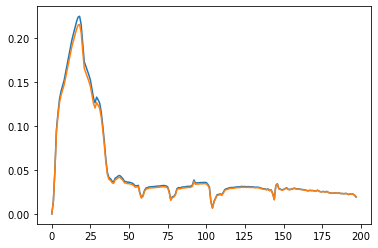

In [997]:
plt.plot(spectrum)
meanspec = (spec1+spec2+spec3+spec4+spec5+spec6+spec7+spec8+spec9+spec10+spec11+spec12+spec13+spec14)/14
plt.plot(meanspec)
if np.linalg.norm(meanspec)>1:
    plt.plot(meanspec/np.linalg.norm(meanspec))

#la moyenne des A perturbés converge vers le A de réfèrence

In [1041]:
spectrum1 = A_jasper_norm[0,:,0]
spec1 = np.reshape(perturbated_spectrum(spectrum1, 0.15, L), (198,1) )

spectrum2 = A_jasper_norm[0,:,1]
spec2 = np.reshape(perturbated_spectrum(spectrum2, 0.15, L), (198,1) )

spectrum3 = A_jasper_norm[0,:,2]
spec3 = np.reshape(perturbated_spectrum(spectrum3, 0.15, L), (198,1) )

spectrum4 = A_jasper_norm[0,:,3]
spec4 = np.reshape(perturbated_spectrum(spectrum4, 0.15, L), (198,1) )

conc = torch.reshape( torch.tensor(np.concatenate((spec1,spec2,spec3,spec4),axis=1)) , [1,198,4])